<a href="https://colab.research.google.com/github/Gcarmnonapy7/LHC_dataset/blob/main/CMS_luminosity_information_for_13TeV_proton_proton_collision_data_taken_in_2016_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q uproot awkward

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.8/383.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.8/886.8 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.3/650.3 kB 20.7 MB/s eta 0:00:00


In [ ]:
import lightgbm as lgb
import xgboost as xgb
import uproot
import awkward
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [ ]:
#Binary classification models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import json
from google.colab import files

In [ ]:
#Downloading data from LHC
!wget https://opendata.cern.ch/record/1059/files/2016lumi.txt
!wget https://opendata.cern.ch/record/1059/files/Run2016Glumi.txt
!wget https://opendata.cern.ch/record/1059/files/Run2016Hlumi.txt
!wget https://opendata.cern.ch/record/1059/files/normtag_PHYSICS_pp_2016.json
!wget https://opendata.cern.ch/record/1059/files/pp_2016lumibyls.csv
!wget https://opendata.cern.ch/record/1059/files/prescale_pp2016.csv

--2025-08-01 12:38:29--  https://opendata.cern.ch/record/1059/files/2016lumi.txt
Resolving opendata.cern.ch (opendata.cern.ch)... 137.138.6.31, 2001:1458:201:8b::100:1c8
Connecting to opendata.cern.ch (opendata.cern.ch)|137.138.6.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33554 (33K) [text/plain]
Saving to: ‘2016lumi.txt’

2016lumi.txt        100%[===================>]  32.77K   216KB/s    in 0.2s    

2025-08-01 12:38:31 (216 KB/s) - ‘2016lumi.txt’ saved [33554/33554]

--2025-08-01 12:38:31--  https://opendata.cern.ch/record/1059/files/pp_2016lumibyls.csv
Resolving opendata.cern.ch (opendata.cern.ch)... 137.138.6.31, 2001:1458:201:8b::100:1c8
Connecting to opendata.cern.ch (opendata.cern.ch)|137.138.6.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21137550 (20M) [text/plain]
Saving to: ‘pp_2016lumibyls.csv.2’

pp_2016lumibyls.csv 100%[===================>]  20.16M  8.76MB/s    in 2.3s    

2025-08-01 12:38:34 (8.76 MB/s) 

In [ ]:
df = pd.read_csv("pp_2016lumibyls.csv",comment="#",header=None)
df.shape

(234231, 9)

In [ ]:
df.columns = ["run_fill","ls","time","beamstatus","energy_GeV","delivered_fb","recorded_fb","avgpu","source"]

In [ ]:
df.head()

,run_fill,ls,time,beamstatus,energy_GeV,delivered_fb,recorded_fb,avgpu,source
0,273158:4915,1:1,05/11/16 20:42:35,STABLE BEAMS,6500,0.000022,1.226600e-05,11.4,PXL
1,273158:4915,2:2,05/11/16 20:42:59,STABLE BEAMS,6500,0.000008,7.154000e-06,4.1,PXL
2,273158:4915,3:3,05/11/16 20:43:22,STABLE BEAMS,6500,0.000047,3.400000e-08,24.6,PXL
3,273158:4915,4:4,05/11/16 20:43:45,STABLE BEAMS,6500,0.000050,4.627000e-06,25.9,PXL
4,273158:4915,5:5,05/11/16 20:44:08,STABLE BEAMS,6500,0.000049,4.346000e-06,25.4,PXL


In [ ]:
df[["run","fill"]] = df["run_fill"].str.split(":",expand=True)
df[["ls_number","ls_index"]] = df["ls"].str.split(":",expand=True)
df.drop(columns=["run_fill","ls"],inplace=True)

In [ ]:
df = df.set_index(["ls_index"])

In [ ]:
df["timestamp"] = pd.to_datetime(df["time"])
df["hour"] = pd.to_datetime(df["timestamp"]).dt.hour
df["day"] = pd.to_datetime(df["timestamp"]).dt.day
df["month"] = pd.to_datetime(df["timestamp"]).dt.month

/tmp/ipython-input-4031548059.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["timestamp"] = pd.to_datetime(df["time"])


In [ ]:
#Convert dtypes properly
df["run"] = df["run"].astype("int")
df["fill"] = df["fill"].astype("int")
df["ls_number"] = df["ls_number"].astype("int")
df["delivered_fb"] = df["delivered_fb"].astype("float")
df["recorded_fb"] = df["recorded_fb"].astype("float")
df["avgpu"] = df["avgpu"].astype("int")

In [ ]:
df["source"].unique()
mapping_source = {
    'PXL':1,
    'HFOC':2,
    'RAMSES':3,
    'DT':4
}
df["source"] = df["source"].map(mapping_source)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 234231 entries, 1 to 30
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   time          234231 non-null  object        
 1   beamstatus    234231 non-null  object        
 2   energy_GeV    234231 non-null  int64         
 3   delivered_fb  234231 non-null  float64       
 4   recorded_fb   234231 non-null  float64       
 5   avgpu         234231 non-null  int64         
 6   source        234231 non-null  object        
 7   run           234231 non-null  int64         
 8   fill          234231 non-null  int64         
 9   ls_number     234231 non-null  int64         
 10  ls_index      234231 non-null  object        
 11  timestamp     234231 non-null  datetime64[ns]
 12  hour          234231 non-null  int32         
 13  day           234231 non-null  int32         
 14  month         234231 non-null  int32         
dtypes: datetime64[ns](1), floa

In [ ]:
# def suplot(df:pd.DataFrame,row:int,col:int):
#   """
#   Suplotting the columns in the dataframe
#   """
#   row = 2
#   col = 3
#   fig,axes = plt.subplot(nrows=row,ncols=col,figsize=(10,10))
#   for i in range(row):
#      for j in range(col):
#         axes[i,j].plot([0,1][i,j])
#         axes[i,j].set_titles(f"title{i,j}")
#   plt.tight_layout()
#   plt.show()

<Axes: xlabel='delivered_fb', ylabel='recorded_fb'>

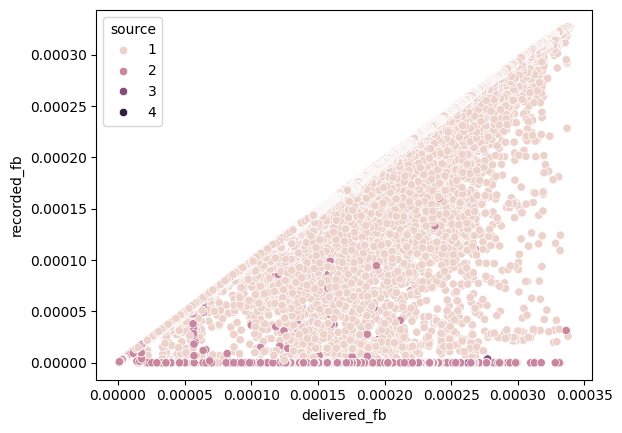

In [ ]:
sns.scatterplot(data=df,x="delivered_fb",y="recorded_fb",hue="source")

In [ ]:
# Mean of the delivered and recorded

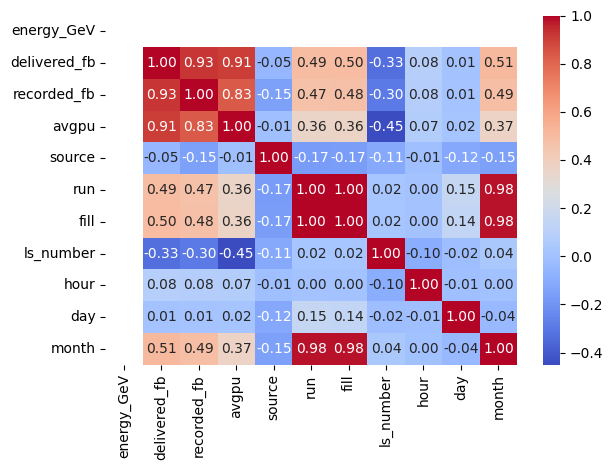

In [ ]:
#Heatmap of correlation
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap="coolwarm",fmt=".2f")
plt.tight_layout()
plt.show()

In [ ]:
models = {
    "LogisticRegression":LogisticRegression(),
    "SVC":SVC(),
    "RandomForestClassifier":RandomForestClassifier(),
    "KNeighborsClassifier":KNeighborsClassifier(),
    "GaussianNB":GaussianNB(),
    "LighthGBM":lgb.LGBMClassifier(),
    "XGBoost":xgb.XGBClassifier()
}

In [ ]:
train_size = int(len(data) * 0.8)

x_train = data[:train_size]
y_train = labels[:train_size]

x_test = data[train_size:]
y_test = labels[train_size:]